In [ ]:
!pip install cassandra-driver matplotlib

In [1]:
!pip install astrapy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.5/333.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 18.2 MB/s eta 0:00:00


Подключение к облаку (Astra DB):

Для работы кода вам понадобится файл secure-connect-bundle.zip (скачивается из панели управления Astra DB)

и Client ID / Secret.

🔌 Подключение к базе данных...
✨ Коллекция 'sensor_metrics' успешно создана.
📡 Генерация телеметрии для устройства fb6852aa...
✅ Успешно загружено 144 записей в облако.
📊 Загрузка данных для анализа...

--- Отчет по устройству fb6852aa... ---
Средняя температура: 46.7°C
Максимальная температура: 51.6°C


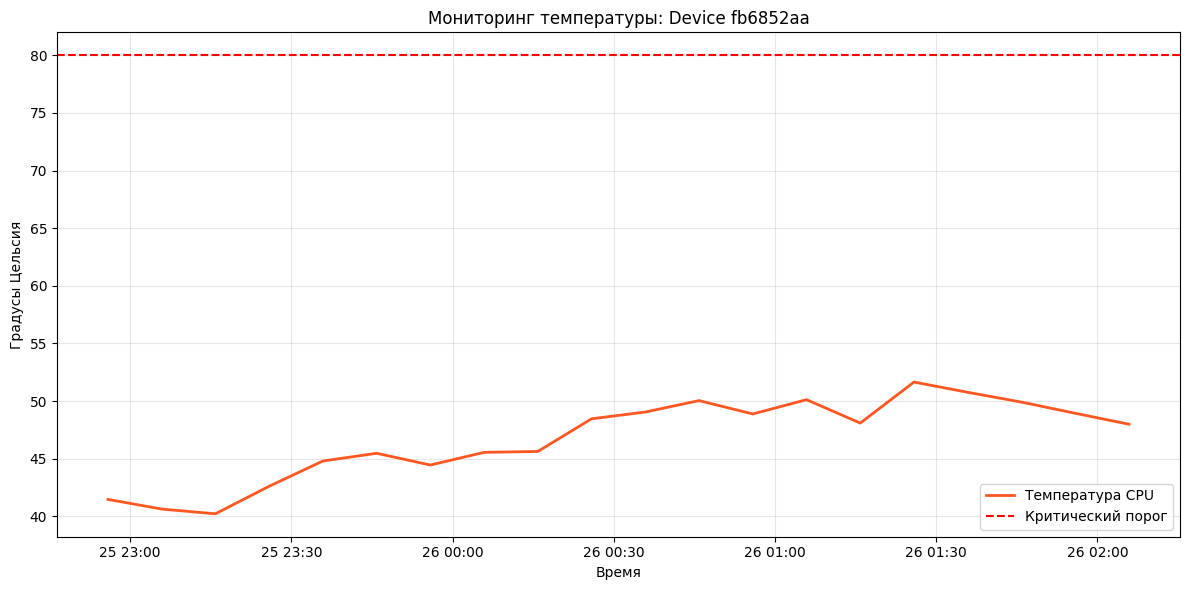

In [ ]:
import random
import math
import datetime
import matplotlib.pyplot as plt
from astrapy import DataAPIClient
from uuid import uuid4

# --- ВАШИ УЧЕТНЫЕ ДАННЫЕ ---
ASTRA_DB_API_ENDPOINT = "_____________________"
ASTRA_DB_APPLICATION_TOKEN = "______________________"

class IoTCloudMonitor:
    def __init__(self, endpoint, token):
        # 1. Подключение к API
        self.client = DataAPIClient(token)
        self.db = self.client.get_database(endpoint)
        self.collection_name = "sensor_metrics"

        print(f"🔌 Подключение к базе данных...")

        # 2. Надежная проверка и создание коллекции
        # Получаем список реальных коллекций с сервера
        existing_collections = self.db.list_collection_names()

        if self.collection_name in existing_collections:
            self.collection = self.db.get_collection(self.collection_name)
            print(f"📂 Коллекция '{self.collection_name}' уже существует.")
        else:
            self.collection = self.db.create_collection(self.collection_name)
            print(f"✨ Коллекция '{self.collection_name}' успешно создана.")

    def generate_and_upload_data(self, device_id, hours=24):
        """Генерация и пакетная загрузка данных"""
        print(f"📡 Генерация телеметрии для устройства {str(device_id)[:8]}...")

        metrics_batch = []
        base_time = datetime.datetime.now() - datetime.timedelta(hours=hours)

        # Генерируем данные каждые 10 минут
        for i in range(hours * 6):
            timestamp = base_time + datetime.timedelta(minutes=10 * i)

            # Симуляция: Температура растет днем и падает ночью + случайный шум
            if 30 < i < 35:
                temp = 85 + random.uniform(0, 5) # Аномальный перегрев
            else:
                # math.sin создает плавную волну
                temp = 40 + 10 * math.sin(i / 10) + random.uniform(-2, 2)

            vibration = random.uniform(0, 5)

            # Формируем JSON документ
            doc = {
                "device_id": str(device_id),
                "timestamp": timestamp.isoformat(),
                "temperature": round(temp, 2),
                "vibration": round(vibration, 2),
                "status": "active"
            }
            metrics_batch.append(doc)

        # 3. Пакетная вставка (Bulk Insert)
        if metrics_batch:
            # Очищаем старые данные этого устройства
            try:
                self.collection.delete_many({"device_id": str(device_id)})
            except Exception as e:
                print(f"⚠️ Предупреждение при очистке: {e}")

            result = self.collection.insert_many(metrics_batch)
            print(f"✅ Успешно загружено {len(result.inserted_ids)} записей в облако.")

    def analyze_data(self, device_id):
        """Выгрузка и визуализация"""
        print("📊 Загрузка данных для анализа...")

        # 4. Поиск данных
        cursor = self.collection.find(
            {"device_id": str(device_id)},
            sort={"timestamp": 1},
            projection={"timestamp": 1, "temperature": 1}
        )

        timestamps = []
        temps = []

        for doc in cursor:
            try:
                dt = datetime.datetime.fromisoformat(doc["timestamp"])
                timestamps.append(dt)
                temps.append(doc["temperature"])
            except Exception:
                continue

        if not temps:
            print("Данные не найдены.")
            return

        # 5. Аналитика
        max_temp = max(temps)
        avg_temp = sum(temps) / len(temps)
        print(f"\n--- Отчет по устройству {str(device_id)[:8]}... ---")
        print(f"Средняя температура: {avg_temp:.1f}°C")
        print(f"Максимальная температура: {max_temp:.1f}°C")

        if max_temp > 80:
            print("⚠️ ВНИМАНИЕ: Зафиксирован критический перегрев (>80°C)!")

        # 6. Визуализация
        plt.figure(figsize=(12, 6))
        plt.plot(timestamps, temps, label='Температура CPU', color='#ff5722', linewidth=2)
        plt.axhline(y=80, color='red', linestyle='--', label='Критический порог')

        plt.title(f"Мониторинг температуры: Device {str(device_id)[:8]}")
        plt.xlabel("Время")
        plt.ylabel("Градусы Цельсия")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

# --- ТОЧКА ВХОДА ---
if __name__ == "__main__":
    try:
        monitor = IoTCloudMonitor(ASTRA_DB_API_ENDPOINT, ASTRA_DB_APPLICATION_TOKEN)

        # Создаем виртуальный датчик
        sensor_uuid = uuid4()

        # Запускаем цикл
        monitor.generate_and_upload_data(sensor_uuid)
        monitor.analyze_data(sensor_uuid)

    except Exception as e:
        print(f"❌ Ошибка: {e}")